# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
### Your code implementation goes here.
### Feel free to use as many code cells as needed.

In [12]:
%matplotlib inline

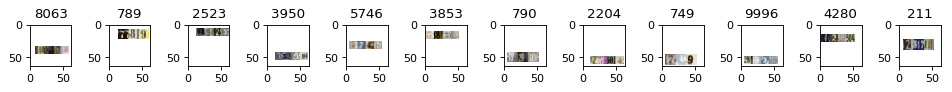

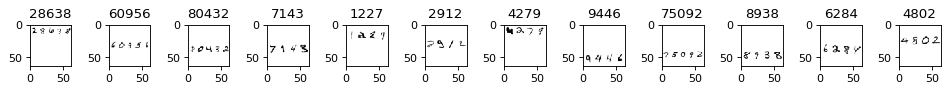

In [15]:
### Test data file download - I'll use MNIST datset
### Thanks to tensorflow. It gives us the api set to support MNIST
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from data_loader import MNISTLoader
from data_loader import SVHNLoader
from data_loader import generate_trainset_testset

mnist_loader = MNISTLoader()
svhn_loader = SVHNLoader()

mnist_mixed_set = generate_trainset_testset(mnist_loader, 'MIXED_data/', 'mnist')
svhn_mixed_set = generate_trainset_testset(mnist_loader, 'MIXED_data/', 'svhn')

mnist_loader.validate_data(mnist_mixed_set["training"][0],
                           mnist_mixed_set["training"][1], 64, 64)
svhn_loader.validate_data(svhn_mixed_set["training"][0],
                          svhn_mixed_set["training"][1], 64, 64)


In [0]:
import gzip

with gzip.open('MNIST_data/train-images-idx3-ubyte.gz') as f:
    file_content = f.read()
    print file_content



In [3]:
# Define placeholder for input images and labels
# Normally we recognize that the first cdimention index as batch size.
# But in most cast, we don't know how big it is. When like this situation,
# we can use None index. (in Numpy, use -1)
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


In [4]:
# Define utility functions for building convolution layers 

def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
    return tf.Variable(tf.zeros(shape))

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], 
                        padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], 
                          strides=[1,2,2,1], 
                          padding='SAME')


In [5]:
# Reshaping line image tensor to rectangular tensor
x_image = tf.reshape(x, [-1, 28, 28, 1])


In [6]:
# Define weight and bias for first convolution layer 
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


In [7]:
# Define wieght and bias for second convolution layer
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


In [8]:
# Define Weight and bias for fully connected layer
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


In [9]:
# Add dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


In [10]:
# Readout layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

pred = tf.matmul(h_fc1_drop, W_fc2)+b_fc2


In [11]:
# Calculate the performance of this training step

# loss calculation
softmax = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred)
loss = tf.reduce_mean(softmax)

# accuracy calculation
is_correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y_, 1))    # it will return the matrix consists of True or False
accuracy = tf.reduce_mean(tf.cast(is_correct_pred, tf.float32))    # But we need to count the number of True 

# Do training until minimizing the loss value
trainer = tf.train.AdamOptimizer(1e-4).minimize(loss)


In [12]:
# Make session and do training

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(20000):
        batch = mnist.train.next_batch(50)

        if not i % 1000:
            # When we calculating the performance, we must not apply dropout
            train_accuracy = accuracy.eval(feed_dict={
                x: batch[0],
                y_: batch[1],
                keep_prob: 1.0
            })
            print "step %d, training_accuracy %g" % (i, train_accuracy)
            
        trainer.run(feed_dict={
            x: batch[0],
            y_: batch[1],
            keep_prob: 0.5
        })
            
    print("test accuracy %g" % accuracy.eval(feed_dict={
        x: mnist.test.images,
        y_: mnist.test.labels,
        keep_prob: 1.0
    }))


test accuracy 0.9921
step 19000, training_accuracy 1
step 18000, training_accuracy 0.98
step 17000, training_accuracy 1
step 16000, training_accuracy 1
step 15000, training_accuracy 1
step 14000, training_accuracy 1
step 13000, training_accuracy 1
step 12000, training_accuracy 1
step 11000, training_accuracy 1
step 10000, training_accuracy 1
step 9000, training_accuracy 1
step 8000, training_accuracy 1
step 7000, training_accuracy 1
step 6000, training_accuracy 0.98
step 5000, training_accuracy 1
step 4000, training_accuracy 1
step 3000, training_accuracy 0.98
step 2000, training_accuracy 1
step 1000, training_accuracy 0.98
step 0, training_accuracy 0.1


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:**

 During the course of Udacity Deep Learning, I thought that it would be possible to construct CNN among the mentioned contents and proceeded while studying related contents.

 First, we configured the Convolutional Network as used in the notMNIST example. In the first layer, the number of feature points was changed to 32. And in the second Convolution Netowrk, we transformed 64 feature points. In order to facilitate back-propagation, the ReLu function is applied to each CN layer as an activation function. We then applied 2x2 Max Pooling to improve learning performance. Therefore, we reduced the image size by 1/2 in every CN layer.

I then had to change to the Fully Connected Layer to match the resulting values to the Label.

 First, we reshape the data output by CN Layer2 and change it to one dimensional Tensor. The image that was 28x28 in size through 2 Max Pooling was changed to 7x7 at this time.

 At this point, each pixel has 64 feature points. Therefore, the size of one dimensional Tensor was deformed to 7 * 7 * 64 length.

 In order to balance the feature points of the created FC layer, dropout was applied to select feature points with a probability of 0.5 at all feature points.

 We then converted the Fully Connected Layer into 10 types of Labeling data we have. (10 because the numbers represent 0 to 9)


### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

The final model constituted a typical CNN.
We applied the 5x5x1x32 patch on the first CN layer, and the 5x5x32x64 patch on the second CNN layer.
After that, we configured Fully Connected Layer and applied Dropout to match the final label.

In other words, you can think that you made five layers in total.
Two Convolution Layer, one Fully Connected Layer, one Dropout Layer, and finally a Readout Layer matching the Lable.

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.